## Pytorch Implementation of "Towards Deep Neural Networks Resistant to Adversarial Attacks"

Model Details: 
Resnet18 \\
CIFAR10 \\
L_inf threat epsilon=8/255

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim

In [2]:
cuda0 = torch.device('cuda:0')
cuda0

device(type='cuda', index=0)

In [3]:
#Scale to [0,1] and normalize
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
        )

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Resnet18 Model
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features,10,bias=True)
model.cuda()
loss_fn = nn.CrossEntropyLoss()

In [5]:
class PGD:
  def __init__(self, network, loss_fn, steps, alpha, epsilon):
    """
    Initialize attack with parameters.
    """
    self.network = network
    self.loss_fn = loss_fn
    self.steps = steps
    self.alpha = alpha
    self.epsilon = epsilon
  def attack(self, X, y, device = None, log = False):
    """
    Projected gradient ascent on self.loss_fn w.r.t. X. If log==True, then 
    vals is the evolution of the loss over iterations. Otherwise, vals = [].
    """
    x0 = X
    vals = []
    for _ in range(self.steps):
      X.requires_grad_()
      loss = self.loss_fn(self.network(X), y).to(device)
      loss.backward()
      if log:
        vals.append(loss)
      X = X + self.alpha*X.grad.sign()
      X = torch.clamp(X, min = x0-self.epsilon, max = x0+self.epsilon)
      X = torch.clamp(X, min=0.0,max=1.0).detach_()
    return X, vals


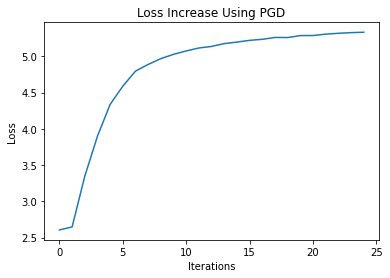

In [6]:
pgd = PGD(model,loss_fn,steps=25,alpha=2/255,epsilon=8/255)
def test_PGD(i):
  """
  Example of PGD applied on an arbitrary batch indexed by i.
  """
  X,y = list(trainloader)[i]
  X,y = X.cuda(), y.cuda()
  model.cuda()
  a, v = pgd.attack(X,y, cuda0, True)
  plt.plot(range(len(v)),[x.item() for x in v])
  plt.title("Loss Increase Using PGD")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
test_PGD(0)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.0003)
model.cuda()
epochs = 6

def train(model, trainloader, epochs, optimizer, attacker, loss_fn):
  """
  Train the model and track the evolution of loss, adversarial accuracy (i.e.
  robust accuracy), and normal accuracy (non-perturbed inputs).
  """
  loss_history = []
  adv_accuracy_history = []
  normal_accuracy_history = []
  for epoch in range(epochs): 
    for i, data in enumerate(trainloader, 0):
        #sample point(s)
        
        X,y = data

        X,y = X.to(cuda0), y.to(cuda0)
        
        optimizer.zero_grad()
        
      
        #compute maximizer of inner problem
        X_adv,_ = pgd.attack(X,y, device=cuda0)
        
        out = model(X_adv.cuda())
        
        #use approximate gradient for minimization 
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss)

        adv_accuracy = torch.sum(torch.argmax(out, dim=1) == y).item()/batch_size
        normal_accuracy = torch.sum(torch.argmax(model(X.cuda()), dim=1) == y).item()/batch_size
        adv_accuracy_history.append(adv_accuracy)
        normal_accuracy_history.append(normal_accuracy)

        if i%10 == 0:
          print(f"iteration {i+1} with loss {loss.item()}", f"{(i+1)*batch_size}/{len(trainloader.dataset)} and adv_accuracy {adv_accuracy}, normal accuracy {normal_accuracy}")
    print("EPOCH", epoch+1, " DONE")

  print('Finished Training')
  return loss_history, adv_accuracy_history,normal_accuracy_history

In [ ]:
loss_history, adv_accuracy_history, normal_accuracy_history = train(model, trainloader, epochs, optimizer, pgd, loss_fn)

## Training Statistics

Each iteration corresponds to a batch of 128 examples.  Trends suggest that parameters can be improved further with more iterations. 

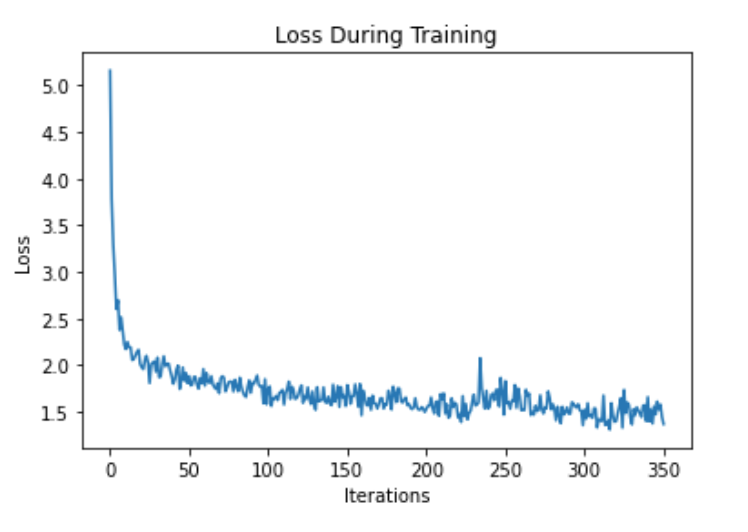

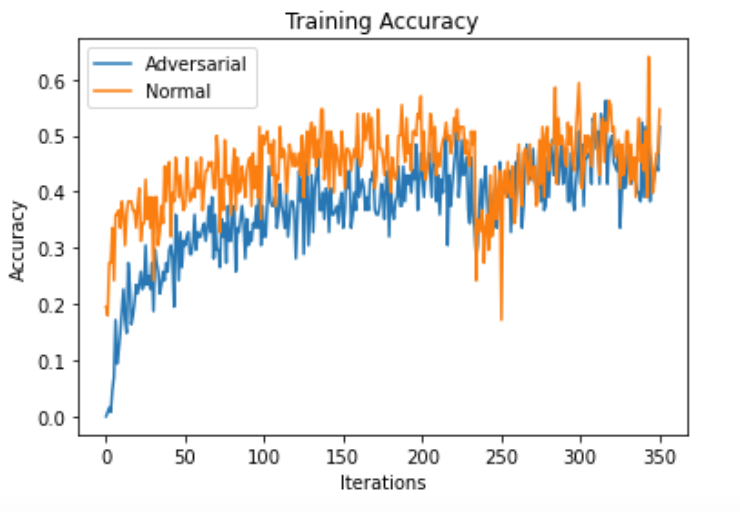

In [8]:
#Evaluation
def test(model):
  """
  Evaluate the model on the test set. As with training, distinguishes between
  and returns adversarial accuracy and normal accuracy.
  """
  correct = 0
  adv_correct = 0
  total = 0

  pgd_test = PGD(model, loss_fn, steps=20,alpha=2/255,epsilon=8/255)

  model.eval()
  for i,data in enumerate(testloader):
      X,y = data
      X,y = X.cuda(), y.cuda()
      adv_X,_ = pgd_test.attack(X,y,device=cuda0)

      adv_c = torch.sum(torch.argmax(model(adv_X), dim=1) == y).item()
      norm_c = torch.sum(torch.argmax(model(X), dim=1) == y).item()
      
      adv_correct += adv_c
      correct += norm_c

      total += batch_size
      print(f'Finished evaluating Batch {i+1} with Normal Accuracy {correct/total} and Adversarial Accuracy {adv_correct/total}')

  print(f'Adv/Normal Accuracy on test images: {100 *  adv_correct// total} %, {100*correct//total}%')
  return correct, adv_correct, total

In [9]:
m = torch.load('full_model.pth')
m.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
test(m)

Finished evaluating Batch 1 with Normal Accuracy 0.4375 and Adversarial Accuracy 0.4296875
Finished evaluating Batch 2 with Normal Accuracy 0.41796875 and Adversarial Accuracy 0.421875
Finished evaluating Batch 3 with Normal Accuracy 0.4114583333333333 and Adversarial Accuracy 0.4296875
Finished evaluating Batch 4 with Normal Accuracy 0.400390625 and Adversarial Accuracy 0.4296875
Finished evaluating Batch 5 with Normal Accuracy 0.4109375 and Adversarial Accuracy 0.4375
Finished evaluating Batch 6 with Normal Accuracy 0.4140625 and Adversarial Accuracy 0.41796875
Finished evaluating Batch 7 with Normal Accuracy 0.421875 and Adversarial Accuracy 0.4140625
Finished evaluating Batch 8 with Normal Accuracy 0.4296875 and Adversarial Accuracy 0.423828125
Finished evaluating Batch 9 with Normal Accuracy 0.4331597222222222 and Adversarial Accuracy 0.4236111111111111
Finished evaluating Batch 10 with Normal Accuracy 0.4328125 and Adversarial Accuracy 0.4265625
Finished evaluating Batch 11 with 

(4257, 4073, 10112)

Overall robust test accuracy 40%, normal accuracy 42%. Can increase with more training.